In [50]:
# LSTM Autoencoder for Multivariate Anomaly Detection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [52]:
battery_temp = pd.read_csv('BatteryTemperature.csv', parse_dates=[0], index_col=0, names=["timestamp", "battery_temp"])
bus_voltage = pd.read_csv('BusVoltage.csv', parse_dates=[0], index_col=0, names=["timestamp", "bus_voltage"])
bus_current = pd.read_csv('TotalBusCurrent.csv', parse_dates=[0], index_col=0, names=["timestamp", "bus_current"])
wheel_rpm = pd.read_csv('WheelRPM.csv', parse_dates=[0], index_col=0, names=["timestamp", "wheel_rpm"])
wheel_temp = pd.read_csv('WheelTemperature.csv', parse_dates=[0], index_col=0, names=["timestamp", "wheel_temp"])


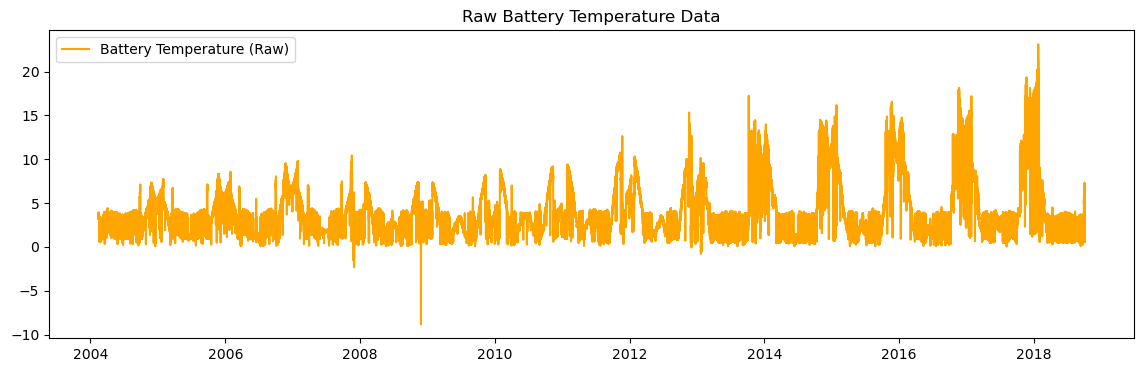

In [53]:
plt.figure(figsize=(14,4))
plt.plot(battery_temp.index, battery_temp['battery_temp'], label='Battery Temperature (Raw)', color='orange')
plt.title('Raw Battery Temperature Data')
plt.legend()
plt.show()

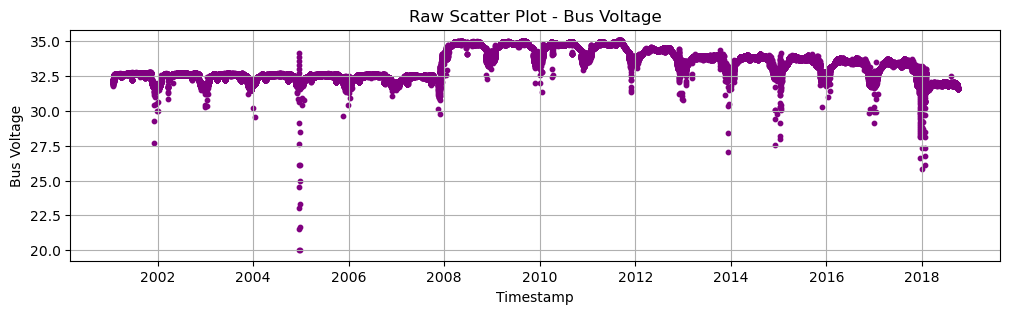

In [56]:
plt.figure(figsize=(12,3))
plt.scatter(bus_voltage.index, bus_voltage['bus_voltage'], color='purple', s=10)  # 's' is size of dots
plt.title('Raw Scatter Plot - Bus Voltage')
plt.xlabel('Timestamp')
plt.ylabel('Bus Voltage')
plt.grid(True)
plt.show()

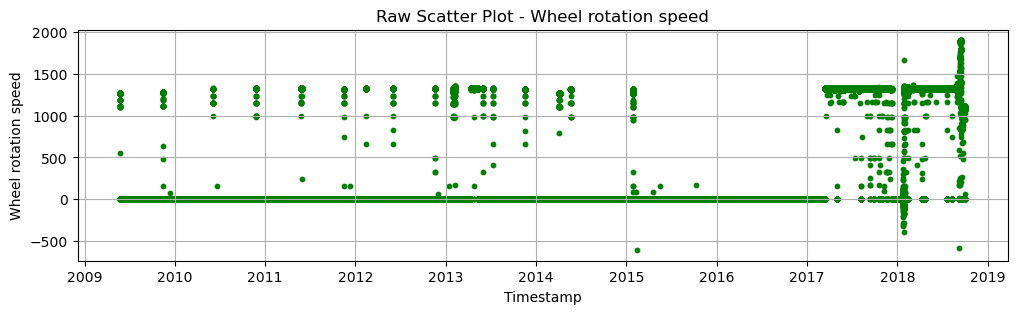

In [58]:
plt.figure(figsize=(12,3))
plt.scatter(wheel_rpm.index, wheel_rpm['wheel_rpm'], color='green', s=10)  # 's' is size of dots
plt.title('Raw Scatter Plot - Wheel rotation speed')
plt.xlabel('Timestamp')
plt.ylabel('Wheel rotation speed')
plt.grid(True)
plt.show()

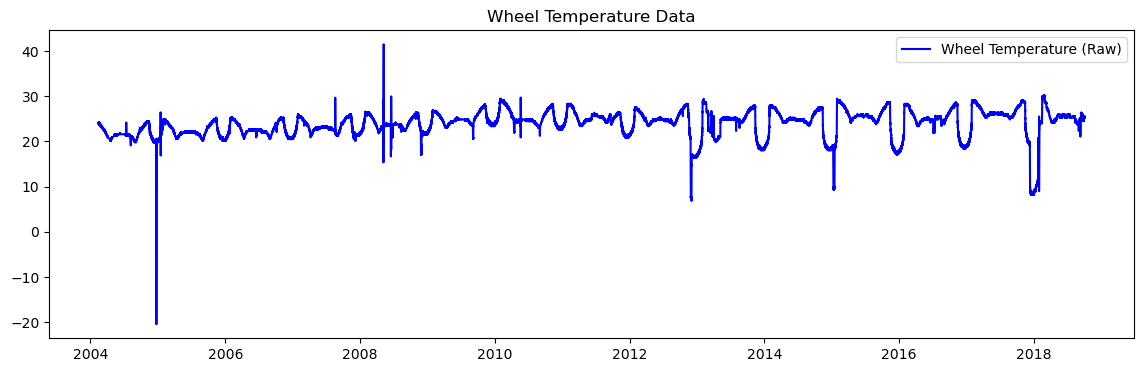

In [60]:
plt.figure(figsize=(14,4))
plt.plot(wheel_temp.index, wheel_temp['wheel_temp'], label='Wheel Temperature (Raw)', color='blue')
plt.title('Wheel Temperature Data')
plt.legend()
plt.show()

In [62]:
battery_temp = battery_temp.resample('1H').mean()
bus_voltage = bus_voltage.resample('3H').mean()
bus_current = bus_current.resample('1D').mean()
wheel_rpm = wheel_rpm.resample('5min').mean()
wheel_temp = wheel_temp.resample('10min').mean()

C:\Users\adith\AppData\Local\Temp\ipykernel_24044\3832845727.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  battery_temp = battery_temp.resample('1H').mean()
C:\Users\adith\AppData\Local\Temp\ipykernel_24044\3832845727.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bus_voltage = bus_voltage.resample('3H').mean()


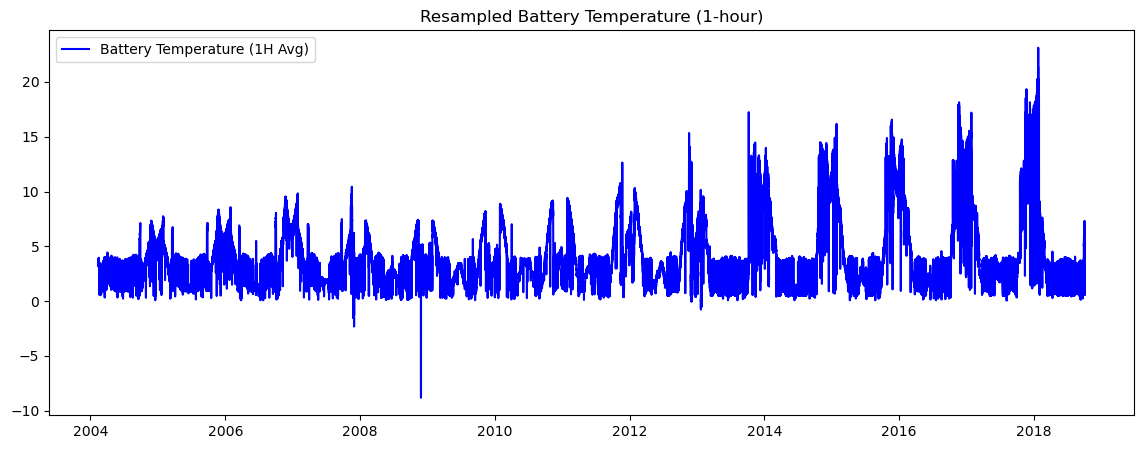

In [64]:
plt.figure(figsize=(14,5))
plt.plot(battery_temp.index, battery_temp['battery_temp'], label='Battery Temperature (1H Avg)', color='blue')
plt.title('Resampled Battery Temperature (1-hour)')
plt.legend()
plt.show()

In [66]:
full_data = battery_temp.join([bus_voltage, bus_current, wheel_rpm, wheel_temp], how='outer')
full_data = full_data.interpolate().dropna()

In [68]:
full_data

,battery_temp,bus_voltage,bus_current,wheel_rpm,wheel_temp
timestamp,,,,,
2009-05-22 22:30:00,1.873130,34.858240,11.264086,1266.527199,24.486791
2009-05-22 22:35:00,1.883519,34.858383,11.264183,1267.382818,24.486791
2009-05-22 22:40:00,1.893909,34.858525,11.264280,1267.260905,24.486791
2009-05-22 22:45:00,1.904298,34.858668,11.264377,1267.305787,24.486791
2009-05-22 22:50:00,1.914687,34.858811,11.264474,1267.859010,24.486791
...,...,...,...,...,...
2018-10-02 23:10:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:20:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:30:00,0.593578,31.536154,5.510878,1031.661722,25.229268


In [70]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_data)


In [72]:
full_data

,battery_temp,bus_voltage,bus_current,wheel_rpm,wheel_temp
timestamp,,,,,
2009-05-22 22:30:00,1.873130,34.858240,11.264086,1266.527199,24.486791
2009-05-22 22:35:00,1.883519,34.858383,11.264183,1267.382818,24.486791
2009-05-22 22:40:00,1.893909,34.858525,11.264280,1267.260905,24.486791
2009-05-22 22:45:00,1.904298,34.858668,11.264377,1267.305787,24.486791
2009-05-22 22:50:00,1.914687,34.858811,11.264474,1267.859010,24.486791
...,...,...,...,...,...
2018-10-02 23:10:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:20:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:30:00,0.593578,31.536154,5.510878,1031.661722,25.229268


In [34]:
# STEP 2: Create sequences for LSTM input
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)


In [36]:
SEQ_LEN = 30  # Window size for time-series sequence
X = create_sequences(scaled_data, SEQ_LEN)

In [31]:
# STEP 3: Build LSTM Autoencoder
n_features = X.shape[2]
input_layer = Input(shape=(SEQ_LEN, n_features))

In [33]:
# Encoder
encoder = LSTM(64, activation='relu', return_sequences=False)(input_layer)
bottleneck = RepeatVector(SEQ_LEN)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)

# Output layer to match original feature size
output = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 5)               │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# STEP 4: Train the model
history = autoencoder.fit(
    X, X,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    shuffle=False
)


Epoch 1/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 396s 14ms/step - loss: 0.0414 - val_loss: 54.6799
Epoch 2/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 384s 14ms/step - loss: 0.0284 - val_loss: 2.1384
Epoch 3/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 390s 14ms/step - loss: 0.0078 - val_loss: 1.2891
Epoch 4/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 380s 14ms/step - loss: 0.0066 - val_loss: 1.1068
Epoch 5/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 384s 14ms/step - loss: 0.0051 - val_loss: 1.0961
Epoch 6/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 384s 14ms/step - loss: 0.0048 - val_loss: 0.7701
Epoch 7/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 387s 14ms/step - loss: 0.0041 - val_loss: 0.6318
Epoch 8/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 385s 14ms/step - loss: 0.0032 - val_loss: 0.5275
Epoch 9/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 387s 14ms/step - loss: 0.0326 - val_loss: 0.3326
Epoch 10/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 389s 14ms/step - loss: 0.0021 - val_loss: 3.6140
Epoch 11/25
27701/27701 ━━━━━━━━━━━━━━━━━━━━ 390s 14ms/step - loss: 

In [37]:
# STEP 5: Detect anomalies using reconstruction error
X_pred = autoencoder.predict(X)
recon_error = np.mean(np.square(X - X_pred), axis=(1, 2))

30779/30779 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step


In [39]:
# Determine threshold (e.g., 95th percentile)
threshold = np.percentile(recon_error, 95)
anomalies = recon_error > threshold

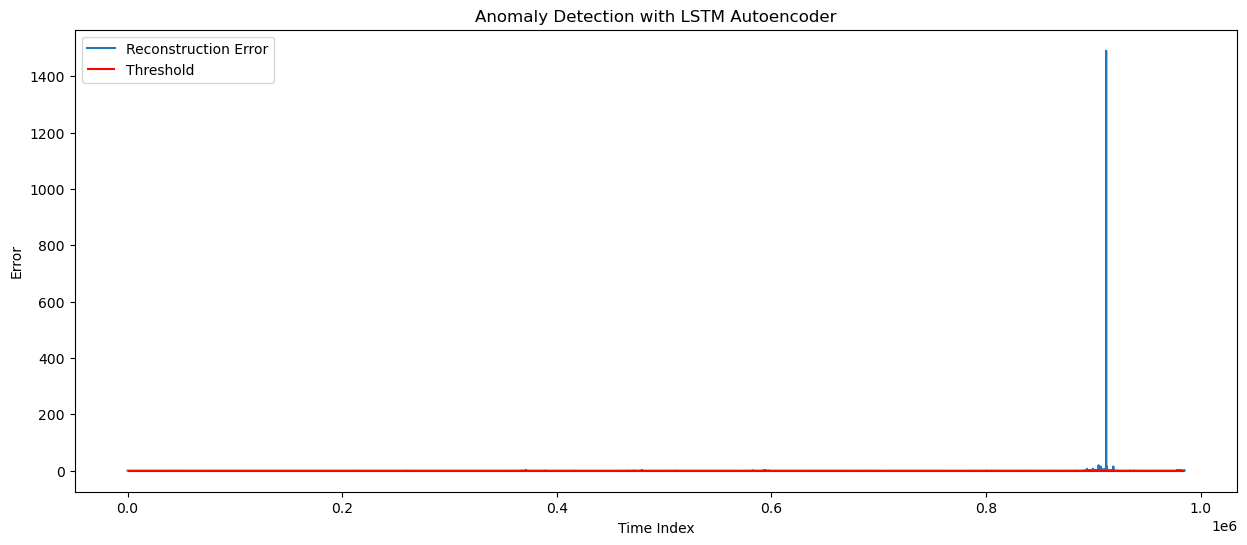

In [41]:
# Plot the reconstruction error
plt.figure(figsize=(15, 6))
plt.plot(recon_error, label='Reconstruction Error')
plt.hlines(threshold, 0, len(recon_error), colors='red', label='Threshold')
plt.title('Anomaly Detection with LSTM Autoencoder')
plt.xlabel('Time Index')
plt.ylabel('Error')
plt.legend()
plt.show()


In [43]:
# Retrieve timestamps for anomalies
anomaly_timestamps = full_data.index[SEQ_LEN:][anomalies]
print("Anomalies detected at:")
print(anomaly_timestamps)


Anomalies detected at:
DatetimeIndex(['2009-05-24 01:35:00', '2009-05-24 01:40:00',
               '2009-05-24 01:45:00', '2009-05-24 01:50:00',
               '2009-05-24 01:55:00', '2009-05-24 02:00:00',
               '2009-05-24 02:05:00', '2009-05-24 02:10:00',
               '2009-05-24 02:15:00', '2009-05-24 02:20:00',
               ...
               '2018-10-02 22:20:00', '2018-10-02 22:30:00',
               '2018-10-02 22:40:00', '2018-10-02 22:50:00',
               '2018-10-02 23:00:00', '2018-10-02 23:10:00',
               '2018-10-02 23:20:00', '2018-10-02 23:30:00',
               '2018-10-02 23:40:00', '2018-10-02 23:50:00'],
              dtype='datetime64[ns]', name='timestamp', length=49246, freq=None)


In [45]:
# Create and save anomaly scores
anomaly_scores = pd.Series(recon_error, index=full_data.index[SEQ_LEN:], name="anomaly_score")
anomaly_scores.to_csv("anomaly_scores.csv")
print("Anomaly scores saved to 'anomaly_scores.csv'")


Anomaly scores saved to 'anomaly_scores.csv'


In [47]:
# STEP 6: Cluster-Based Validation via PCA on Bottleneck
encoder_model = Model(autoencoder.input, autoencoder.get_layer(index=2).output)
bottleneck_features = encoder_model.predict(X)

# Ensure bottleneck features are 2D
bottleneck_flat = bottleneck_features.reshape((bottleneck_features.shape[0], -1))

pca = PCA(n_components=2)
components = pca.fit_transform(bottleneck_flat)



30779/30779 ━━━━━━━━━━━━━━━━━━━━ 341s 11ms/step


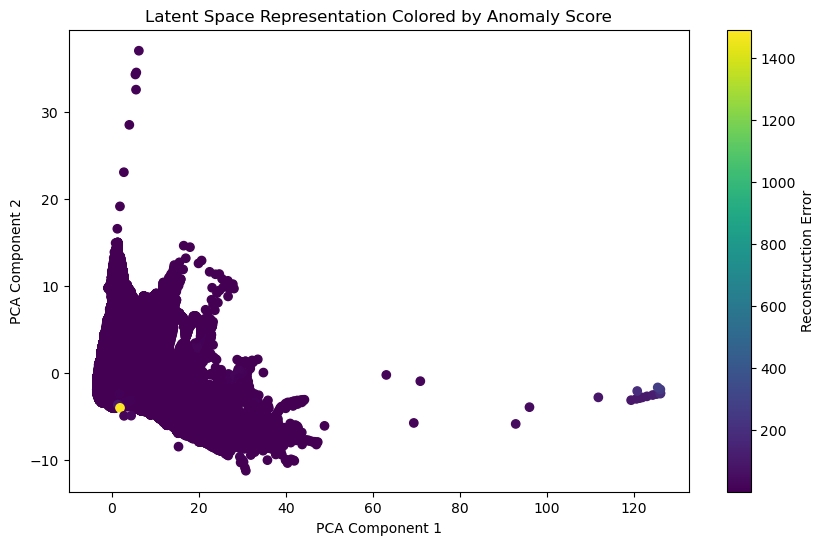

In [48]:

plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1], c=recon_error, cmap='viridis')
plt.colorbar(label="Reconstruction Error")
plt.title("Latent Space Representation Colored by Anomaly Score")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

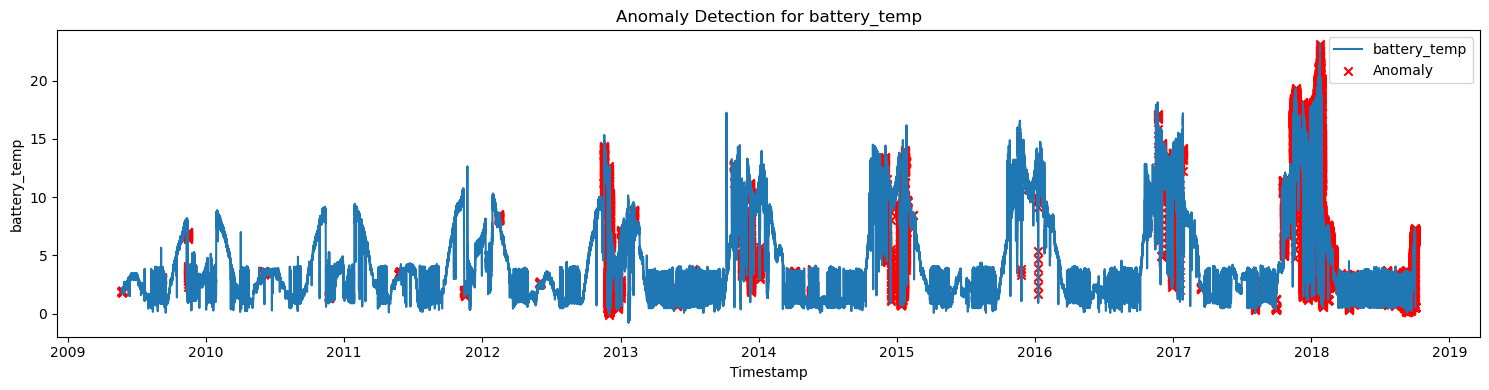

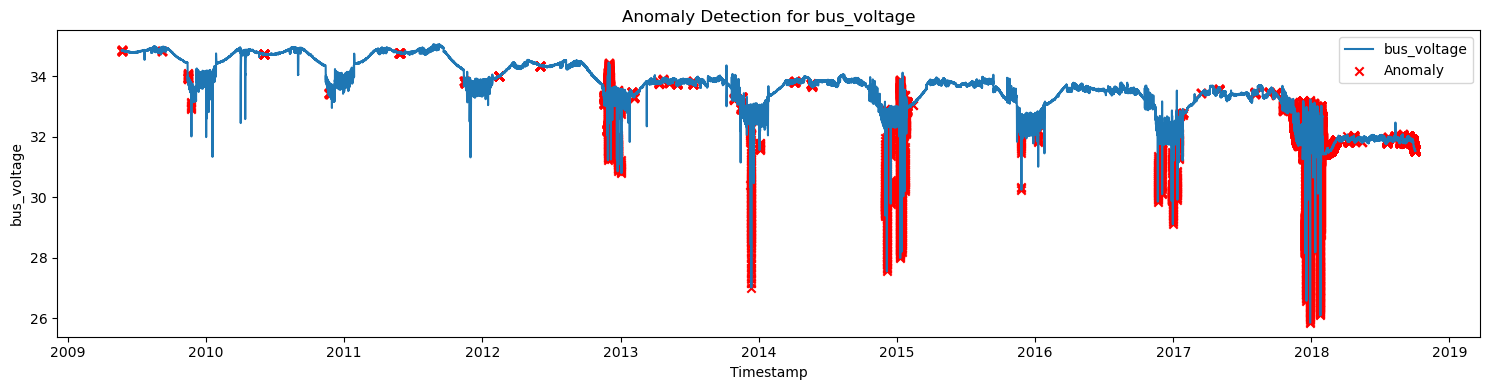

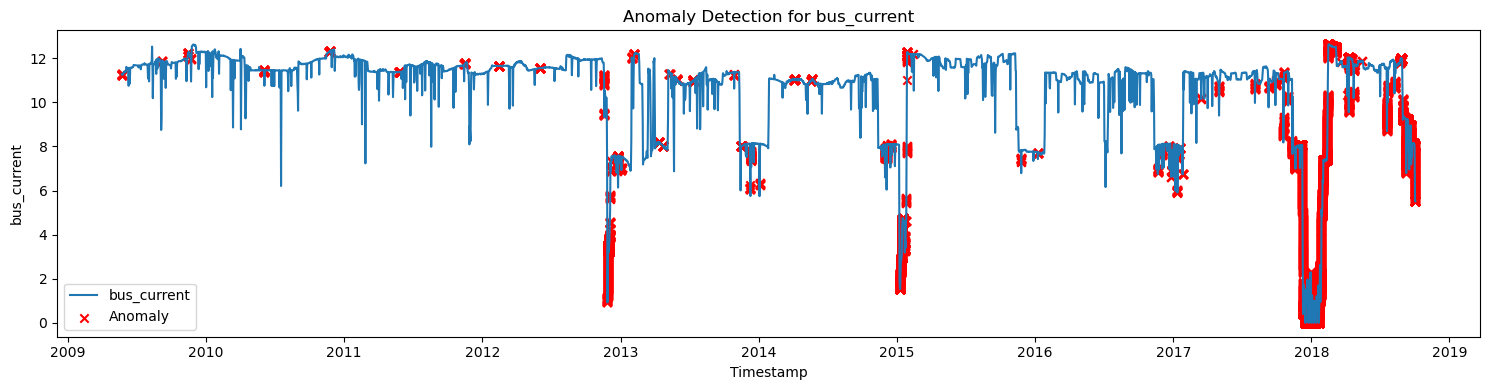

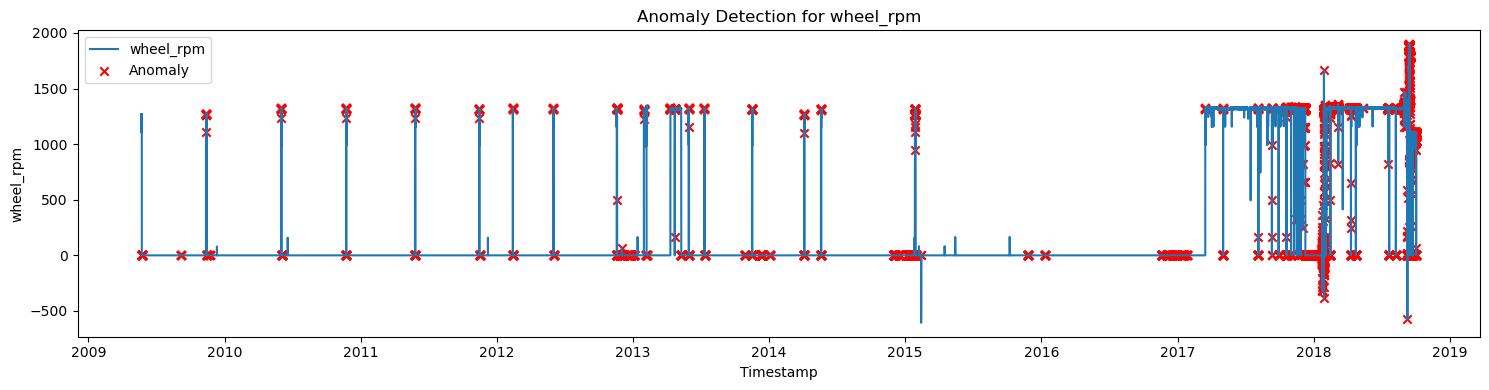

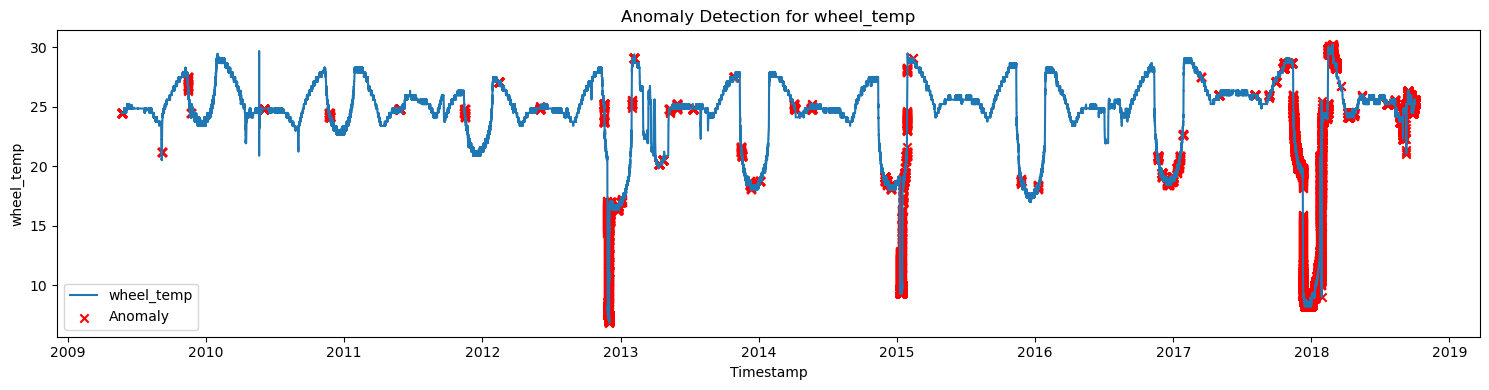

In [51]:
# Generate binary anomaly labels
anomaly_flags = (anomaly_scores > threshold).astype(int)

# Get the timestamp-aligned data post sequence creation
aligned_data = full_data.iloc[SEQ_LEN:]

# Plot anomaly detection for each feature
for column in aligned_data.columns:
    plt.figure(figsize=(15, 4))
    plt.plot(aligned_data.index, aligned_data[column], label=column)
    plt.scatter(aligned_data.index[anomaly_flags == 1],
                aligned_data[column][anomaly_flags == 1],
                color='red', marker='x', label='Anomaly')
    plt.title(f"Anomaly Detection for {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()